In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind', n_colors=5576)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
matplotlib.rcParams['font.family'] = 'serif'
import os
import glob
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
import pickle
pkl_file = open(__outdir__+'K_tempscale_Clump/astero_0.0_fullchain_dict.pkl', 'rb')
fit = pickle.load(pkl_file)
pkl_file.close()

IOError: [Errno 2] No such file or directory: '/Users/Oliver/PhD/Gaia_Project/Output/K_tempscale_Clump/astero_0.0_fullchain_dict.pkl'

## Lets look at our seismic posterior outputs
Conditions: RC, K, 0., full sample

In [ ]:
def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [ ]:
x = np.linspace(-1.9, -1.6,1000)
mu = np.median(fit['mu'],axis=0)
sigma = np.median(fit['sigma'],axis=0)
y = normal(x, mu, sigma)

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


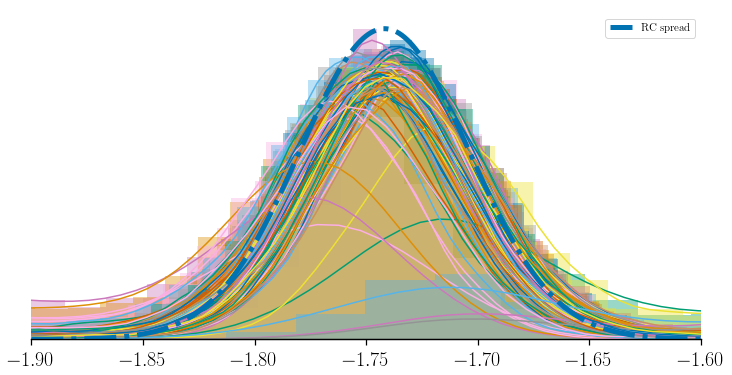

In [5]:
Mi = fit['Mtrue'].T
fig, ax = plt.subplots(figsize=(12,6))
for i in range(100):
    sns.distplot(Mi[i],ax=ax)
axr = ax.twinx()
axr.plot(x, y, linewidth=5, linestyle='-.', label='RC spread')
axr.legend()
ax.set_xlim(-1.9, -1.6)
axr.set_ylim(0.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
axr.spines['top'].set_visible(False)
axr.spines['right'].set_visible(False)
axr.spines['left'].set_visible(False)
ax.set_yticks([])
axr.set_yticks([])
plt.show()

Okay, so the posteriors on M_true seem to be very similar to the position and spread of the clump, not formed of multiple smaller posteriors. This means that we probably can't improve the accuracy on the Gaia run by including these posteriors, but we *can* speed it up by feeding in initial guesses.

## Lets run our model twice, with and without initial guesses

In [6]:
import pystan
astrostan = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
    real precalc_multinormal_lpdf(vector oo, vector oo_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;       
        r = oo - oo_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }    
}
data {
    int<lower = 0> N;
    real<lower= 0> Nfloat;
    vector[N] m;
    vector<lower=0>[N] m_err;
    vector[N] oo;
    vector<lower=0>[N] RlEbv;

    matrix[N, N] invc;
    real logdetc;

    real mu_init;
    real mu_spread;
    real sig_init;
    real sig_spread;
    
}
parameters {
    //Hyperparameters
    real mu;
    real<lower=0.> sigma;
    real<lower=1.> sigo;
    real<lower=0.5,upper=1.> Q;
    real<lower=.1, upper=4000.> L;
    real oo_zp;

    //Latent parameters
    vector[N] M_infd_std;
    vector[N] Ai;
    vector<lower = 1.>[N] r_infd;
}
transformed parameters{
    //Inferred and transformed parameters
    vector[N] M_infd;

    //Operations
    for (n in 1:N){
        M_infd[n] = mu + sigma * M_infd_std[n]; //Rescale the M fit
    }
}
model {
    //Define calculable properties
    vector[N] m_true;
    vector[N] oo_true;

    //Hyperparameters [p(theta_rc, L)]
    mu ~ normal(mu_init, mu_spread); // Prior from seismo
    sigma ~ normal(sig_init, sig_spread);
    Q ~ normal(1., .25);
    sigo ~ normal(3.0, 1.0);
    L ~ uniform(0.1, 4000.);   // Prior on the length scale
    oo_zp ~ normal(0.0, 500.); // Prior on the offset (in mu as)

    //Latent parameters [p(alpha_i | theta_rc, L)]
    Ai ~ normal(RlEbv, 0.05);
    for (n in 1:N){
        r_infd[n] ~ bailerjones(L);
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0., 1.),
            normal_lpdf(M_infd_std[n] | 0., sigo));
    }

    //Calculable properties
    for (n in 1:N){
        m_true[n] = M_infd[n] + 5*log10(r_infd[n]) - 5 + Ai[n];
        oo_true[n] = (1000./r_infd[n]) + (oo_zp/1000.);
    }

    //Observables [p(D | theta_rc, L, alpha)]
    oo ~ precalc_multinormal(oo_true, logdetc, invc, N, Nfloat);      
    m ~ normal(m_true, m_err); //Measurement uncertainty on magnitude
}

'''
sm_full = pystan.StanModel(model_code = astrostan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_22253de495c27d8e5bd9314ae79aedd0 NOW.


In [27]:
from sklearn.utils import shuffle
kdf = pd.read_csv('/home/oliver/PhD/Gaia_Project/data/KepxDR2/rcxyu18.csv')
mu = np.median(fit['mu'],axis=0)
sigma = np.median(fit['sigma'],axis=0)
Q = np.median(fit['Q'],axis=0)
sigo = np.median(fit['sigo'],axis=0)
kdf['M_infd'] = np.median(fit['Mtrue'],axis=0)
kdf['M_infd_std'] = np.median(fit['Mtrue_std'],axis=0)
kdf['r_infd'] = kdf.r_est.values

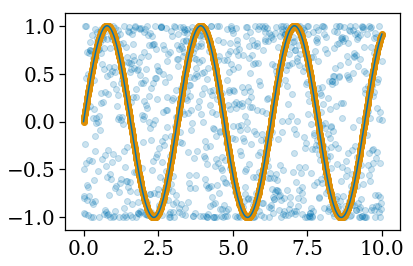

In [11]:
x = np.linspace(0., 10, 1000)
y = np.sin(2.*x)
plt.plot(x,y)

from sklearn.utils import shuffle
xs = shuffle(x)
ys = shuffle(y)
plt.scatter(xs, ys, alpha=.2)

xt = shuffle(x,random_state=24601)
yt = shuffle(y,random_state=24601)
plt.scatter(xt, yt)

Targets in our dataframe: 500


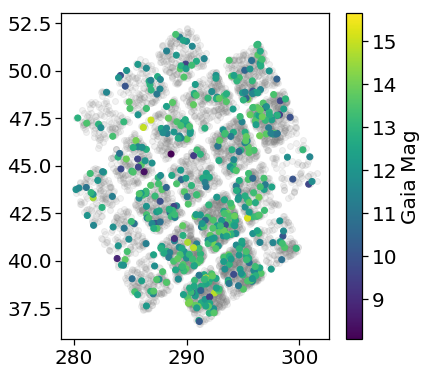

In [43]:
kdf = shuffle(kdf, random_state=24601).reset_index(drop=True)
nstars = 500
df = kdf[:nstars]
print('Targets in our dataframe: '+str(len(df)))
f,a = plt.subplots(figsize=(6,6))
a.scatter(kdf.ra, kdf.dec, c = 'grey', alpha=.1)
c = a.scatter(df.ra, df.dec, c=df.GAIAmag, cmap='viridis')
f.colorbar(c, label=r"Gaia Mag")
plt.show()

In [44]:
def kernel(ra, dec, sigma, p):
    '''
    p[0] : Offset
    p[1] : Exponential decay scale
    '''
    thetaij = np.sqrt(np.subtract.outer(ra, ra)**2 + np.subtract.outer(dec, dec)**2)
    cov = p[0] * np.exp(-thetaij / p[1])
    np.fill_diagonal(cov, np.diag(cov) + sigma**2)
    return cov

In [45]:
p = [285.0*10**-6, 14.]
Sigma = kernel(df.ra.values, df.dec.values, df.parallax_error.values, p)
invc = np.linalg.inv(Sigma)
logdetc = np.linalg.slogdet(Sigma)[1] * np.linalg.slogdet(Sigma)[0]

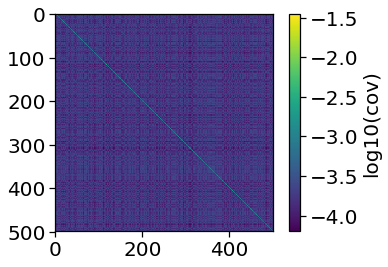

In [46]:
c = plt.imshow(np.log10(Sigma))
plt.colorbar(c, label='log10(cov)')
plt.show()
if not np.all(np.linalg.eigvals(Sigma) > 0):
    raise ValueError("The matrix isn't positive-definite for some reason!")

In [47]:
rlebv = df.Aks.values
mband = df.Kmag.values
merr = df.e_Kmag.values
tempdiff = 0.0

dat = {'N':len(df),
       'Nfloat':np.float(len(df)),
        'm': mband,
        'm_err': merr,
        'oo': df.parallax.values,
        'RlEbv': rlebv,
        'logdetc': logdetc,
        'invc': invc,
        'mu_init': np.median(fit['mu'],axis=0),
        'mu_spread': np.std(fit['mu'],axis=0),
        'sig_init': np.median(fit['sigma'],axis=0),
        'sig_spread': np.std(fit['sigma'],axis=0),}

### Run with no initial guesses for latent parameters

In [48]:
init= {'mu': mu,
    'sigma': sigma,
    'Q': Q,
    'sigo': sigo,
    'L': 1000.,
    'oo_zp':-29.}

In [49]:
noinit_fit = sm_full.sampling(data=dat, iter=5000, chains=4, seed=24601, init=[init for i in range(4)])

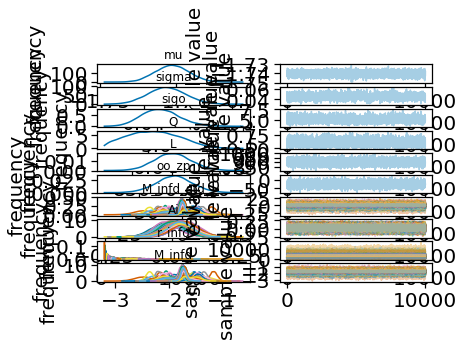

In [50]:
matplotlib.rcParams['text.usetex']=False
noinit_fit.plot()
plt.show()

This took **3964/4525/4762/5821** seconds for **500** stars

### Run *with* initial guesses for latent parameters

In [51]:
init= {'mu': mu,
    'sigma': sigma,
    'Q': Q,
    'sigo': sigo,
    'L': 1000.,
    'oo_zp':-29.,
    'M_infd' : df.M_infd,
    'M_infd_std' : df.M_infd_std,
    'r_infd' : df.r_infd,
    'Ai' : rlebv}

In [52]:
init_fit = sm_full.sampling(data=dat, iter=5000, chains=4, seed=24601, init=[init for i in range(4)])

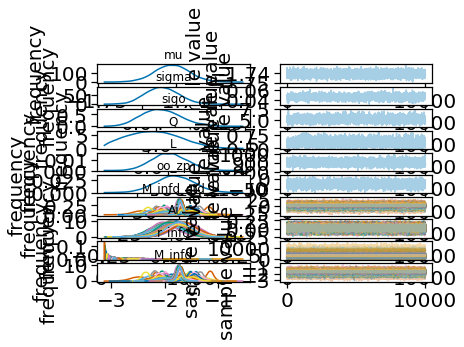

In [53]:
init_fit.plot()
plt.show()

Without initial guesses:
This took **3964/4525/4762/5821** seconds for **500** stars

With initial guesses:
This took **2708/2962/3062/3084** seconds for **500** stars

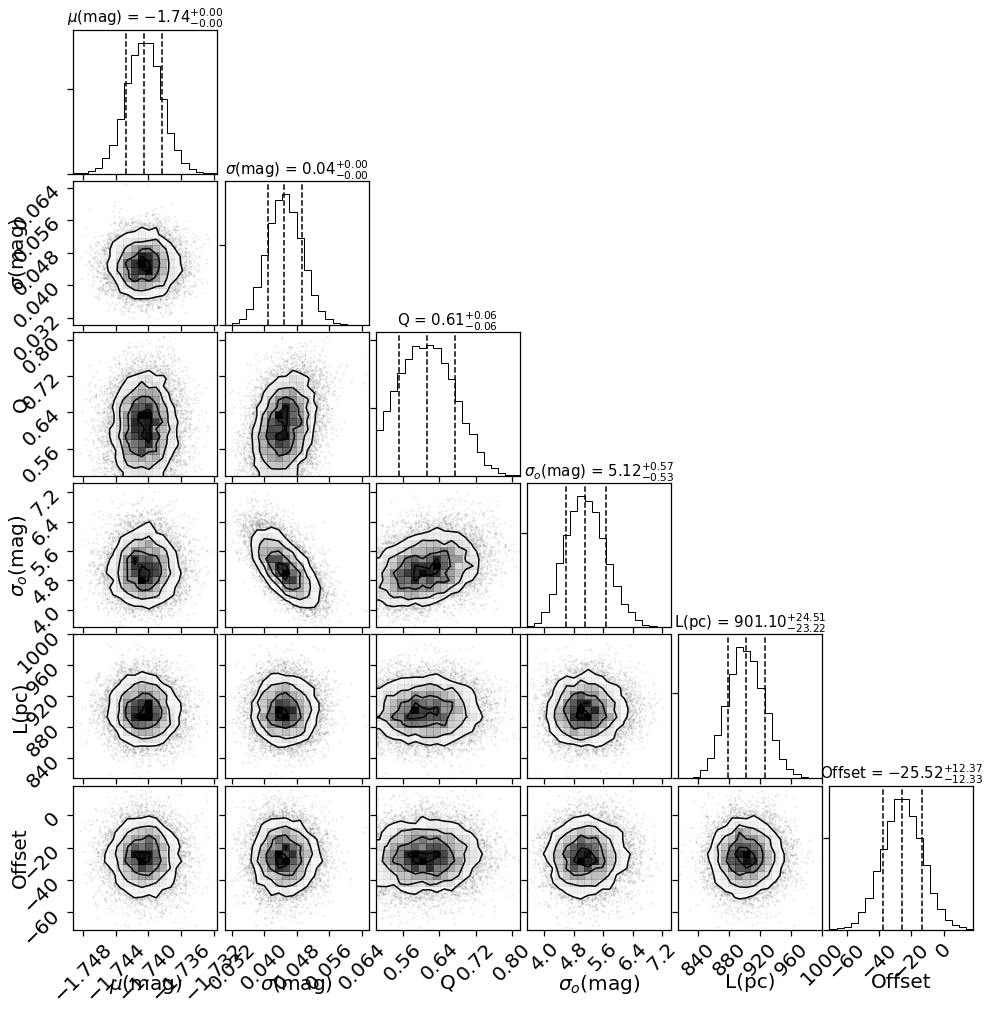

In [54]:
import corner
chain = np.array([init_fit['mu'],init_fit['sigma'],init_fit['Q'],init_fit['sigo'],init_fit['L'], init_fit['oo_zp']])
corner.corner(chain.T,\
                labels=[r'$\mu$(mag)',r'$\sigma$(mag)','Q',r'$\sigma_o$(mag)','L(pc)', 'Offset'],\
                quantiles=[0.16, 0.5, 0.84],\
                show_titles=True, title_kwargs={"fontsize": 15})
plt.show()

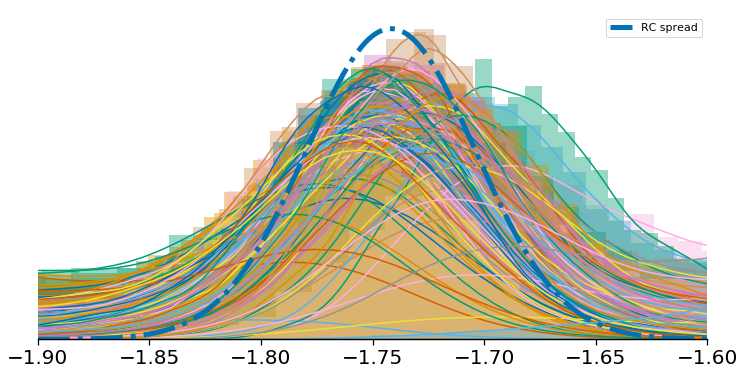

In [55]:
Mi = init_fit['M_infd'].T
fig, ax = plt.subplots(figsize=(12,6))
for i in range(100):
    sns.distplot(Mi[i],ax=ax)
axr = ax.twinx()
axr.plot(x, y, linewidth=5, linestyle='-.', label='RC spread')
axr.legend()
ax.set_xlim(-1.9, -1.6)
axr.set_ylim(0.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
axr.spines['top'].set_visible(False)
axr.spines['right'].set_visible(False)
axr.spines['left'].set_visible(False)
ax.set_yticks([])
axr.set_yticks([])
plt.show()

This is weird, as it looks like the apparent magnitudes are much less well constrained. Could we feed in the posteriors on the apparent magnitudes from asteroseismology into our Gaia model? Or would that be too computationally expensive?
